# Modelo para decisão de concessão de crédito (risco de crédito)

#### Por: Leticia Campos Valente -> [LinkedIn](https://www.linkedin.com/in/leticia-campos-valente/)

\**Inspirada na solução de Odemir Depieri Jr, Ronisson Lucas C. da Conceição e Yan Vianna Sym*

# 0. Importações

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Modelos a serem testados
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# 1. Descrição dos dados

+ **Age** = Idade do solicitante (numérico)
+ **Sex** = Gênero (texto: male, female)
+ **Job** = (numérico(classe): 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
+ **Housing** = Como é a moradia. Se é proprietário, aluga ou gratuita(texto: own, rent, or free)
+ **Saving accounts** = Poupança pequena, moderada, rica, muito rica (texto - little, moderate, quite rich, rich)
+ **Checking account** = Categórico sobre valor na conta corrente 
+ **Credit amount** = Valor de crédito que pegou emprestado(numerico, em DM - Deutsch Mark)
+ **Duration** = Duração do empréstimo (numérico, em meses)
+ **Purpose** = Propósito do crédito, e.g carro, mobilia/equipamento, etc (texto: carr, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [2]:
df_credit = pd.read_csv('german_credit_data.csv')
print(df_credit.columns)

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose'],
      dtype='object')


In [3]:
# Essa coluna Unnamed normalmente vem quando o csv é exportado pelo pandas sem dar drop de index, sendo redundante a este, então:
df_credit = df_credit.drop(columns='Unnamed: 0')
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


# 2. EDA e limpeza dos dados

### 2.1 Checagem de tipo dos dados e se batem com a descrição

In [4]:
print('---------------------------------------Tipos das colunas no dataframe')
print(df_credit.dtypes)

# Como mencionado anteriormente que Job é uma espécie de classe e não número contínuo ou ordenado:
df_credit['Job'] = df_credit.Job.astype('category')
print('---------------------------------------Depois da tipagem correta')
df_credit.dtypes

---------------------------------------Tipos das colunas no dataframe
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object
---------------------------------------Depois da tipagem correta


Age                    int64
Sex                   object
Job                 category
Housing               object
Saving accounts       object
Checking account      object
Credit amount          int64
Duration               int64
Purpose               object
dtype: object

### 2.2 Contagem de nulos e discussão da correção

In [5]:
#Verificando quais colunas possuem valores nulos
(df_credit.isnull().sum() / df_credit.shape[0] * 100).sort_values(ascending=False).loc[lambda x : x > 0]

Checking account    39.4
Saving accounts     18.3
dtype: float64

Percebe-se +-40% de nulos em Checking account e +-19% em Savings account, arredondando pro próximo inteiro acima.

**Como tratar?**
40%, em drop, é uma perda muito considerável de dados. Além disso, são informações muito importantes pro modelo, assim, opto pelo inputing ao invés de uma simples remoção. 
Duas coisas passaram pela minha cabeça: Ou está nulo porque não tem nenhum dinheiro/valor nessas contas ou realmente não se conseguiram estas informações, talvez por políticas de onde se obteve o dado. O tratamento de nulos será feito mais a frente, no final de feature engineering e explicarei o porquê.

Por enquanto, vamos olhar agora as distribuições para as colunas categóricas.


### 2.3 Visualização de distribuições categóricas e numéricas

In [6]:
numeric_columns = df_credit.select_dtypes(include=np.number).columns.tolist()
categoric_columns = df_credit.select_dtypes(exclude=np.number)

#### 2.3.1 Categóricas

In [7]:
for col in categoric_columns:
    print(col)
    print(categoric_columns[col].unique());print()

Sex
['male' 'female']

Job
[2, 1, 3, 0]
Categories (4, int64): [0, 1, 2, 3]

Housing
['own' 'free' 'rent']

Saving accounts
[nan 'little' 'quite rich' 'rich' 'moderate']

Checking account
['little' 'moderate' nan 'rich']

Purpose
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']



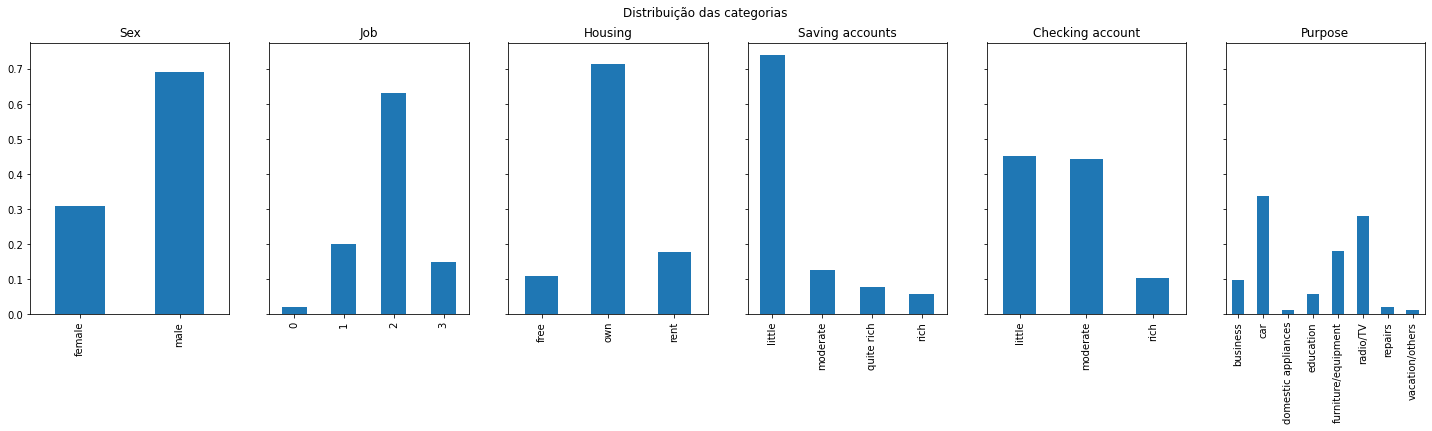

In [8]:
fig, axs = plt.subplots(1, len(categoric_columns.columns.tolist()), figsize=(25, 5), sharey=True)
fig.suptitle('Distribuição das categorias')
for i,col in enumerate(categoric_columns.columns.tolist()):
    df_credit[col].value_counts(normalize = True).sort_index().plot(kind = 'bar', ax=axs[i])
    axs[i].set_title(col)

Percebemos que, para Saving Acounts, substituir os valores nulos com 'little', que seria a moda, poderia ser uma solução se não tivesse uma quantidade considerável de nulos, porque fazer isso desbalancearia mais ainda os dados e poderia induzir alguns resultados em modelos, caso se notasse ser uma grande feature importance. Então não é uma solução plausível

Adotarei então a abordagem de ***kNN inputing*** que é nada mais é usar o algoritimo de nearest neighbors para prever o valor das classes de saving e checking de acordo com as outras informações. A efetividade é verificada pela não alteração das distribuições categóricas. Mas, para isso, é preciso fazer feature engineering e passar todas as variáveis para tipos numéricos e outras preparações, como essencial para interpretação de qualquer modelo. Trataremos então os nulos ao final desses preparos.

#### 2.3.2 Numéricas

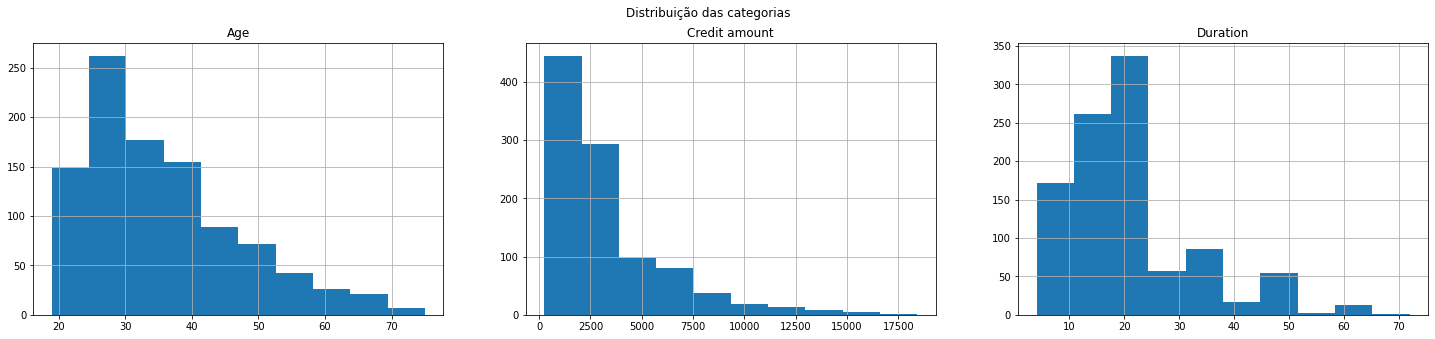

In [9]:
fig, axs = plt.subplots(1, len(numeric_columns), figsize=(25, 5))
fig.suptitle('Distribuição das categorias')
for i,col in enumerate(numeric_columns):
    df_credit[col].hist(ax=axs[i])
    axs[i].set_title(col)

Em sua maioria, assimétricos para esquerda, indicando mais dados de pessoas entre 20 e 30 anos, 0-2500DM em crédito e 10-30 meses de duração do empréstimo

In [10]:
# Complementando a visualização do histograma
df_credit.describe(percentiles=[0.001, .01, .1, .25, .5, .75, .9, .99, .999]).T

,count,mean,std,min,0.1%,1%,10%,25%,50%,75%,90%,99%,99.9%,max
Age,1000.0,35.546,11.375469,19.0,19.000,20.00,23.0,27.0,33.0,42.00,52.0,67.01,75.000,75.0
Credit amount,1000.0,3271.258,2822.736876,250.0,275.974,425.83,932.0,1365.5,2319.5,3972.25,7179.4,14180.39,15947.479,18424.0
Duration,1000.0,20.903,12.058814,4.0,4.000,6.00,9.0,12.0,18.0,24.00,36.0,60.00,60.012,72.0


# 3. Data treatment / feature engineering

Neste dataset em específico, optei não fazer remoção de outliers uma vez que os outliers podem ser exatamente parte da reposta que procuramos.

### 3.1 Feature engineering de categóricas

In [11]:
# Categorias que existem certo tipo de ordenação podem ser diretamente categorizadas em números, apesar de também tipar na frente como categoria. Em ordem de importância para o risco.

df_credit['Saving accounts'] = df_credit['Saving accounts'].map({'rich': 0, 'quite rich': 1, 'moderate': 2, 'little': 3})
df_credit['Checking account'] = df_credit['Checking account'].map({'rich': 0, 'moderate': 1, 'little': 2 })
df_credit['Housing'] = df_credit['Housing'].map({'own': 0, 'rent': 1, 'free': 2 })


# As demais serão separadas em categorias binárias por não poder se definir alguma ordem de importância, usando o método one-hot encoding

df_credit['Sex'] = df_credit['Sex'].map({'male': 0, 'female': 1}).astype(int)

purposes = pd.get_dummies(df_credit['Purpose'])
df = pd.concat([df_credit.drop(columns='Purpose'), purposes], axis=1)

df[['Saving accounts', 'Checking account', 'Housing', 'Sex']] = df[['Saving accounts', 'Checking account', 'Housing', 'Sex']].astype('category')

In [12]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
0,67,0,2,0,NaN,2.0,1169,6,0,0,0,0,0,1,0,0
1,22,1,2,0,3.0,1.0,5951,48,0,0,0,0,0,1,0,0
2,49,0,1,0,3.0,NaN,2096,12,0,0,0,1,0,0,0,0
3,45,0,2,2,3.0,2.0,7882,42,0,0,0,0,1,0,0,0
4,53,0,2,2,3.0,2.0,4870,24,0,1,0,0,0,0,0,0


### 3.2 Feature engineering de numéricas

In [13]:
""" Como Age e Duration tem um período limitado, um range, optou-se pela normalização, também conhecido como Min Max Scaler, uma vez que apenas irá enquadrar os números em um range de 0-1, 
aumentando a velocidade de processamento do modelo."""

df['Age'] = (df.Age - df.Age.min()) / (df.Age.max() - df.Age.min())

# Já para a quantidade de crédito, como, técnicamente não possui nenhum range ou limite, opto pelo standardScaler, uma vez que este não tentará enquadrar os números, apenas transformar

df['Credit amount'] = StandardScaler().fit_transform(df['Credit amount'].values.reshape(-1, 1))

In [14]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
0,0.857143,0,2,0,NaN,2.0,-0.745131,6,0,0,0,0,0,1,0,0
1,0.053571,1,2,0,3.0,1.0,0.949817,48,0,0,0,0,0,1,0,0
2,0.535714,0,1,0,3.0,NaN,-0.416562,12,0,0,0,1,0,0,0,0
3,0.464286,0,2,2,3.0,2.0,1.634247,42,0,0,0,0,1,0,0,0
4,0.607143,0,2,2,3.0,2.0,0.566664,24,0,1,0,0,0,0,0,0


### 3.3 Tratamento de nulos

Passamos então para o tratamento de nulos por kNN inputing, como mencionado anteriormente, uma vez as demais variáveis todas estarem pré-processadas

In [15]:
imputer = KNNImputer(n_neighbors=2) #O mais próximo
X = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

#### 3.3.1 Comparação

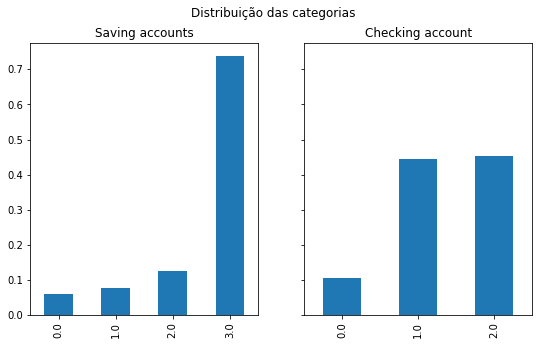

In [16]:
null_columns = ['Saving accounts', 'Checking account']
fig, axs = plt.subplots(1, len(null_columns), figsize=(9, 5), sharey=True)
fig.suptitle('Distribuição das categorias')
for i,col in enumerate(null_columns):
    df_credit[col].value_counts(normalize = True).sort_index().plot(kind = 'bar', ax=axs[i])
    axs[i].set_title(col)

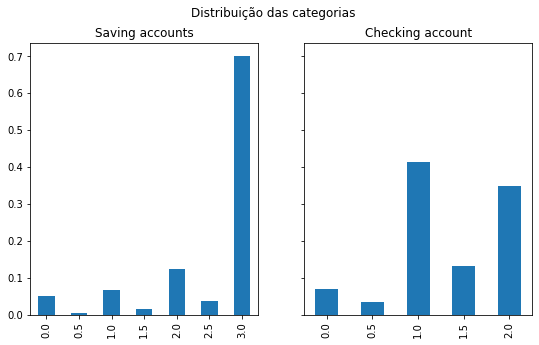

In [17]:
fig, axs = plt.subplots(1, len(null_columns), figsize=(9, 5), sharey=True)
fig.suptitle('Distribuição das categorias')
for i,col in enumerate(null_columns):
    X[col].value_counts(normalize = True).sort_index().plot(kind = 'bar', ax=axs[i])
    axs[i].set_title(col)

Perceba que as distribuições foram afetadas em poucos pontos percentuais e mantiveram a característica da distribuição em sua maior parte, apesar de notarmos diferenças. Não acentuou-se apenas uma classe como um input pela moda faria. Podemos prosseguir então para a elaboração do modelo

### 3.4 Variável target

Geralmente se dá muita importancia pra PREDIÇÃO da variável target, se é um bom ou mal empréstimo(o nível do risco se vê depois disso)

Para mim, mais delicado e crucial ainda, e o que mais dou atenção, é na CONSTRUÇÃO desta variável. Classificar um empréstimo como bom ou ruim envolve assumir varias coisas e pode facilmente determinar o nível de sucesso de todo o processo de modelagem.

Como este notebook é apenas um exemplo de como podemos fazer essa abordagem com esse dataset específico, vou tomar apenas o tempo de empréstimo (Duration) como parâmetro para definir um empréstimo como ruim ou bom, em minha própria assunção. O limite para bom/ruim deve variar de acordo com o observado no negócio e, se possível, previamente tabelado

Arbitráriamente escolhi >18 meses de duração(ou atraso, de acordo com minha interpretação) um 'mal' empréstimo. Poderia também considerar o valor, mas, para fins de conhecimento, será adotada a abordagem mais simples.

Assim,

In [18]:
df['target'] = df['Duration'].apply(lambda x: 0 if x<=18 else 1)
y = df['target']
df.drop(columns = 'Duration', inplace=True)

0 = Não arriscado; 1 = Arriscado

In [19]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others,target
0,0.857143,0,2,0,NaN,2.0,-0.745131,0,0,0,0,0,1,0,0,0
1,0.053571,1,2,0,3.0,1.0,0.949817,0,0,0,0,0,1,0,0,1
2,0.535714,0,1,0,3.0,NaN,-0.416562,0,0,0,1,0,0,0,0,0
3,0.464286,0,2,2,3.0,2.0,1.634247,0,0,0,0,1,0,0,0,1
4,0.607143,0,2,2,3.0,2.0,0.566664,0,1,0,0,0,0,0,0,1


#### 3.4.1 Explorando o balanço entre emprestimo arriscado/não e demais variáveis categóricas

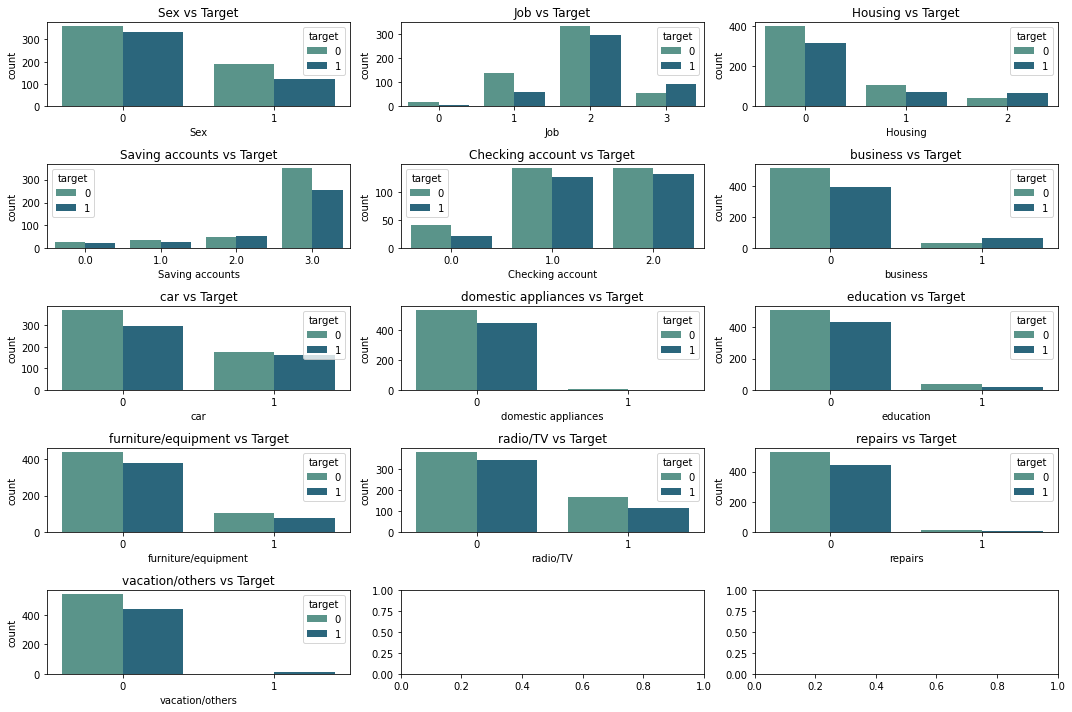

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))

categorical_vars = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 
                    'business', 'car', 'domestic appliances', 'education', 'furniture/equipment', 'radio/TV', 'repairs', 'vacation/others']

for i, var in enumerate(categorical_vars):
    row = i // 3  # Calculando o índice da linha para fazer com que sejam 3 gráficos por linha
    col = i % 3   # Calculando i índice da coluna

    sns.countplot(x=var, hue="target", data=df, ax=axes[row, col], palette = "crest")
    axes[row, col].set_title(f'{var} vs Target')

# Ajuste de espaço entre gráficos
plt.tight_layout()

plt.show()

Como, por sorte, ficou bem balanceado, nenhuma tratativa ou sampling será feito para corrigir classes nesse notebook.

# 4. Preparativos e treino do modelo

In [21]:
X.columns = X.columns.str.replace('[ ,/]', '_', regex=True)
X.drop(columns='Duration', inplace=True)
X.head()

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,business,car,domestic_appliances,education,furniture_equipment,radio_TV,repairs,vacation_others
0,0.857143,0.0,2.0,0.0,2.0,2.0,-0.745131,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.053571,1.0,2.0,0.0,3.0,1.0,0.949817,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.535714,0.0,1.0,0.0,3.0,1.5,-0.416562,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.464286,0.0,2.0,2.0,3.0,2.0,1.634247,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.607143,0.0,2.0,2.0,3.0,2.0,0.566664,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.1 Escolha de um modelo a partir da validação k-cross

Foi escolhido o ROC_AUC como medida de scoring pois a abordagem é mais sensível à classificação de risco positiva pois erros podem significar perda de grandes oportunidades pro agente de empréstimo.

In [22]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
xgb = XGBClassifier()

models = [('knn', knn), ('RandomForest', rf), ('LogisticRegression', lr), ('DecisionTree', dt), ('XGBoost', xgb)]
for model in models:
    # cv=5 -> StratifiedKfold(k=5) de acordo com a documentação do cross_val_score
    scores = cross_val_score(model[1], X.values, y, cv=5, scoring='roc_auc')
    print(model[0])
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))


knn
Accuracy: 0.738 (+/- 0.073)
RandomForest
Accuracy: 0.797 (+/- 0.053)
LogisticRegression
Accuracy: 0.802 (+/- 0.058)
DecisionTree
Accuracy: 0.627 (+/- 0.088)
XGBoost
Accuracy: 0.771 (+/- 0.065)


Não fora do esperado, LogisticRegression obteve a melhor média de resultados na validação em diferentes participações, logo, será escolhido para prosseguir.

### 4.2 Tuning de hiperparâmetros

\* Nota, fiz alguns testes de range de max iter para melhoria na performance que não estão nesse notebook para não ficar muito extenso, por isso esses números finais nos params.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.33)

params = {
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'class_weight':[None, 'balanced'],
    'max_iter':[500, 700 , 1000]
}
#'penalty':'l2' por default]
clf1 = GridSearchCV(lr, params) 
clf1.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_iter': [500, 700, 1000],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']})

In [24]:
first_cv_results = pd.DataFrame(clf1.cv_results_)
first_cv_results[first_cv_results['rank_test_score']==1].sort_values(by='mean_fit_time').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.002393,0.000489,0.001197,0.000399,balanced,700,liblinear,"{'class_weight': 'balanced', 'max_iter': 700, 'solver': 'liblinear'}",0.746269,0.723881,0.776119,0.768657,0.776119,0.758209,0.020355,1
25,0.002588,0.000801,0.001397,0.000799,balanced,1000,liblinear,"{'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'liblinear'}",0.746269,0.723881,0.776119,0.768657,0.776119,0.758209,0.020355,1
15,0.007180,0.006892,0.001796,0.000747,balanced,500,liblinear,"{'class_weight': 'balanced', 'max_iter': 500, 'solver': 'liblinear'}",0.746269,0.723881,0.776119,0.768657,0.776119,0.758209,0.020355,1


Pelos resultados e menor tempo de fit, solver liblinear com 'balanced' class_weight demonstrou melhor performance. 

Como liblinear aceita regularização/penalidade tanto por l1 e l2, um último gridsearch é feito para conferência se não há melhora usando 'l1', antes de avaliamos então a matriz de confusão do clf final

In [25]:
lr_class = LogisticRegression(class_weight='balanced', max_iter=700, solver='liblinear')

params = {
    'penalty':['l1', 'l2']
}

clf = GridSearchCV(lr_class, params)
clf.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced', max_iter=700,
                                          solver='liblinear'),
             param_grid={'penalty': ['l1', 'l2']})

In [26]:
seccond_cv_results = pd.DataFrame(clf.cv_results_)
seccond_cv_results[seccond_cv_results['rank_test_score']==1].sort_values(by='mean_fit_time').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.002992,0.001092,0.001597,0.000488,l2,{'penalty': 'l2'},0.746269,0.723881,0.776119,0.768657,0.776119,0.758209,0.020355,1
0,0.003590,0.000797,0.001596,0.000489,l1,{'penalty': 'l1'},0.738806,0.738806,0.776119,0.768657,0.768657,0.758209,0.016075,1


Seguimos então para avaliação de demais métricas

In [27]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       190
           1       0.66      0.59      0.62       140

    accuracy                           0.70       330
   macro avg       0.69      0.68      0.68       330
weighted avg       0.69      0.70      0.69       330



Como visto, o modelo teve uma dificuldade maior em prever a classe de risco, o que é muito explicado pela escolha das classes ter sido baseada apenas em um parâmetro (Duration).

# 5. Definindo um score

Para continuar então para o 'score', utilizarei as probabilidades de cada classe para obter pontuações de acordo com a probabilidade de ser risco (classe 1), para isso, farei em cima do X_test já que não foram separada mais parcelas dos dados (devido a quantidade de amostras que teria por dataset)

In [28]:
y_pred_proba = clf.predict_proba(X_test)
credit_risk_scores = X_test.reset_index(drop=True)
credit_risk_scores['target'] = y_test.values
credit_risk_scores['score'] = np.multiply(y_pred_proba[:, 0], 1000).astype(int) # Em uma escala de 1000 para ficar mais compreensível, sendo mais próximo de 1000 -> maior probabilidade de ser bom
credit_risk_scores = credit_risk_scores.sort_values(by='score')

In [29]:
credit_risk_scores.head()

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,business,car,domestic_appliances,education,furniture_equipment,radio_TV,repairs,vacation_others,target,score
98,0.107143,0.0,2.0,0.0,3.0,1.0,3.951952,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
109,0.875000,0.0,3.0,0.0,3.0,2.0,4.120313,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
87,0.142857,0.0,3.0,0.0,3.0,1.0,3.812301,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
269,0.339286,1.0,3.0,2.0,3.0,1.0,3.439781,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4
239,0.089286,1.0,1.0,1.0,2.0,1.5,2.948523,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8


# 6. Definindo critérios de aceite de solicitação de crédito

Explicação: Separei primeiro em grupos de 100 em 100 de score (10 decis) para observar se tinha limiares claros de risco alto/médio/baixo

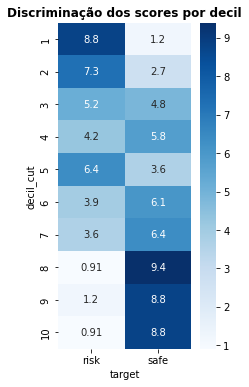

In [36]:
credit_risk_scores['decil_cut'] = pd.qcut(credit_risk_scores.score, 10, labels = [i for i in range(1, 11)])

decile_df = pd.crosstab(
credit_risk_scores['decil_cut'],
credit_risk_scores['target'].map({1:'risk', 0: 'safe'}),normalize = True) * 100

fig, ax = plt.subplots(figsize = (3, 6))
ax.set_title('Discriminação dos scores por decil', weight = 'bold')
sns.heatmap(decile_df, cmap = 'Blues', annot = True, ax = ax)
plt.show()

De acordo com os resultados, chego à conclusão:

### **De 800-1000 de score**: Conceder

### **De 300-799 de score**: Avaliar usando outros critérios

### **De 100-299 de score**: Recusar

### \* Nota final: Como foi explicado ao longo do desenvolvimento, foi feita uma escolha de target muito basica nessa abordagem que talvez não seja suficiente para realmente classificar um empréstimo como bom ou ruim. O principal objetivo deste arquivo é mostrar um tipo de solução para este problema em um toy dataset.

Espero que tenham gostado! :)